In [1]:
!free -h

              total        used        free      shared  buff/cache   available
Mem:          7.8Gi       1.2Gi       5.6Gi        61Mi       1.0Gi       6.2Gi
Swap:            0B          0B          0B


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import seaborn as sns
import gc

In [3]:
df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-11.parquet')

In [4]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,2024-11-01 00:46:24,2024-11-01 00:57:17,1.0,1.93,1.0,N,239,262,2,-12.8,-1.0,-0.5,0.0,0.0,-1.0,-17.8,-2.5,0.0
1,2,2024-11-01 00:46:24,2024-11-01 00:57:17,1.0,1.93,1.0,N,239,263,2,12.8,1.0,0.5,0.0,0.0,1.0,17.8,2.5,0.0
2,1,2024-11-01 00:37:36,2024-11-01 01:28:36,1.0,34.30,5.0,N,219,265,1,259.0,0.0,0.0,15.0,0.0,1.0,275.0,0.0,0.0
3,2,2024-11-01 00:12:55,2024-11-01 00:22:17,2.0,0.93,1.0,N,186,107,1,10.0,1.0,0.5,1.0,0.0,1.0,16.0,2.5,0.0
4,2,2024-11-01 00:54:45,2024-11-01 00:59:47,1.0,0.38,1.0,N,79,79,1,6.5,1.0,0.5,1.0,0.0,1.0,12.5,2.5,0.0


## Calculating duration

In [5]:
df['duration'] = df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']
df['duration_minutes'] = df['duration'].dt.total_seconds() / 60

In [6]:
df['duration'].describe()

count                      3646369
mean     0 days 00:17:47.288417326
std      0 days 00:33:09.711682470
min              -1 days +23:01:47
25%                0 days 00:08:03
50%                0 days 00:13:23
75%                0 days 00:21:38
max                3 days 23:51:17
Name: duration, dtype: object

In [7]:
df['date'] = df['tpep_pickup_datetime'].dt.date
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,duration,duration_minutes,date
0,2,2024-11-01 00:46:24,2024-11-01 00:57:17,1.0,1.93,1.0,N,239,262,2,...,-0.5,0.0,0.0,-1.0,-17.8,-2.5,0.0,0 days 00:10:53,10.883333,2024-11-01
1,2,2024-11-01 00:46:24,2024-11-01 00:57:17,1.0,1.93,1.0,N,239,263,2,...,0.5,0.0,0.0,1.0,17.8,2.5,0.0,0 days 00:10:53,10.883333,2024-11-01
2,1,2024-11-01 00:37:36,2024-11-01 01:28:36,1.0,34.30,5.0,N,219,265,1,...,0.0,15.0,0.0,1.0,275.0,0.0,0.0,0 days 00:51:00,51.000000,2024-11-01
3,2,2024-11-01 00:12:55,2024-11-01 00:22:17,2.0,0.93,1.0,N,186,107,1,...,0.5,1.0,0.0,1.0,16.0,2.5,0.0,0 days 00:09:22,9.366667,2024-11-01
4,2,2024-11-01 00:54:45,2024-11-01 00:59:47,1.0,0.38,1.0,N,79,79,1,...,0.5,1.0,0.0,1.0,12.5,2.5,0.0,0 days 00:05:02,5.033333,2024-11-01


In [8]:
df['date'] = pd.to_datetime(df['date'])
df = df.loc[(df['date'] > pd.Timestamp("2024-10-31")) & 
            (df['date'] <= pd.Timestamp("2024-11-30"))].copy()

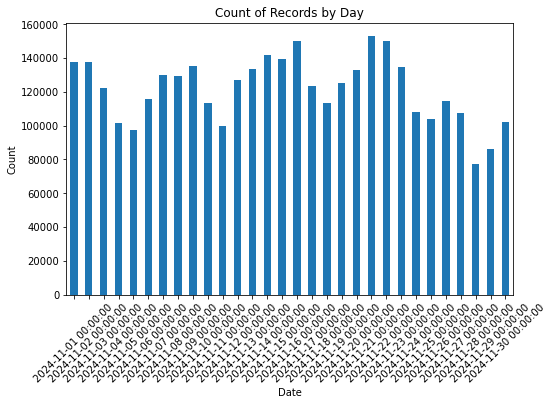

In [9]:
date_counts = df['date'].value_counts().sort_index()

# Plot histogram
date_counts.plot(kind='bar', figsize=(8,5))
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Count of Records by Day')
plt.xticks(rotation=45)
plt.show()

<AxesSubplot:ylabel='Frequency'>

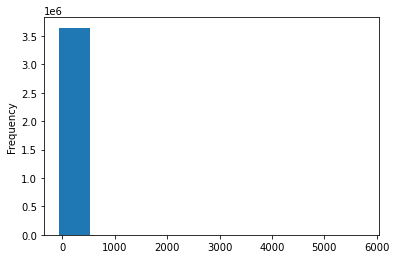

In [10]:
df['duration_minutes'].plot.hist()

## Select trips between 1 and 60 minutes

In [11]:
(df.loc[(df.duration_minutes >= 1 ) & (df.duration_minutes <= 60)].shape[0])/(df.shape[0])

0.9673459727467618

In [12]:
df = df.loc[(df.duration_minutes >= 1 ) & (df.duration_minutes <= 60)].copy()

In [13]:
df.shape #2,898,888

(3527252, 22)

## One hot encoding for categories

In [14]:
categorical = ['PULocationID', 'DOLocationID']
df[categorical] = df[categorical].astype(str)

In [15]:
train_dicts = df[categorical].to_dict(orient='records')

In [16]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [17]:
X_train.shape

(3527252, 517)

## Model training

In [18]:
y_train = df['duration_minutes'].values

In [19]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [20]:
y_pred = lr.predict(X_train)
print(f'Train RMSE: {mean_squared_error(y_train, y_pred, squared=False)}')

Train RMSE: 9.023149657359115


In [ ]:
sns.histplot(y_pred, label='prediction',color='red')
sns.histplot(y_train, label='actual', color='blue', alpha=0.5)

plt.legend();

In [21]:
!free -h

              total        used        free      shared  buff/cache   available
Mem:          7.8Gi       5.2Gi       1.6Gi        61Mi       1.0Gi       2.2Gi
Swap:            0B          0B          0B


In [22]:
# Save reference to model
model = lr  
keep_vars = {'model', 'gc', 'dv', 'pd', 'np', 'plt', 'DictVectorizer', 'LinearRegression', 'mean_squared_error', 
             'sns', 'categorical'}

# Clear all other variables from global scope
for var in list(globals()):
    if var not in keep_vars and not var.startswith("_"):
        del globals()[var]

# Force garbage collection
gc.collect()

6526

In [23]:
!free -h

              total        used        free      shared  buff/cache   available
Mem:          7.8Gi       2.7Gi       4.0Gi        61Mi       1.0Gi       4.6Gi
Swap:            0B          0B          0B


## Running on December dataset

In [24]:
def process_data(url, start_date, end_date):
    _df = pd.read_parquet(url)
    
    _df['duration'] = _df['tpep_dropoff_datetime'] - _df['tpep_pickup_datetime']
    _df['duration_minutes'] = _df['duration'].dt.total_seconds() / 60
    _df = _df.loc[(_df.duration_minutes >= 1 ) & (_df.duration_minutes <= 60)].copy()
    
    _df['date'] = _df['tpep_pickup_datetime'].dt.date
    _df['date'] = pd.to_datetime(_df['date'])
    _df = _df.loc[(_df['date'] > pd.Timestamp(start_date)) & 
            (_df['date'] <= pd.Timestamp(end_date))].copy()
    
    _df[categorical] = _df[categorical].astype('str')
    return _df

In [25]:
dec = process_data('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-12.parquet', 
                   "2024-11-30", "2024-12-31")

In [26]:
dec_val_dicts = dec[categorical].to_dict(orient='records')

In [27]:
X_val = dv.transform(dec_val_dicts) 
y_val = dec.duration_minutes.values

In [28]:
y_pred = model.predict(X_val)

In [29]:
print(f'Val RMSE: {mean_squared_error(y_val, y_pred, squared=False)}')

Val RMSE: 9.754467754227132
